In [1]:
import qsample as qs
import time
import stim
import numpy as np
import matplotlib.pyplot as plt
import time
import re
from tqdm.notebook import tqdm
import random

# Helpers

In [2]:
def dem2matrices(dem, n_detectors):
    
    txt = dem.split('\n')[1:-1]
    dims = len(txt)
    errors = np.zeros(dims)
    err_locs = np.zeros((dims, n_detectors))

    for i in range(dims):
        errors[i] = re.findall('\d?\.?\d+e?\-?\d+', txt[i])[0]
        for j in re.findall('D\d', txt[i]):

            err_locs[i, int(j[1])]=1

    return errors, err_locs

def separate_errors(eloc, dep):

    extracted = [0]*dep
    extracted_indices = [0]*dep
    index = 0
    for ii in range(dep):
        extracted_indices[ii]=index
        index_new = sum(eloc[index:,ii]==1)+index
        extracted[ii] = eloc[index:index_new]
        index=index_new
    return extracted, extracted_indices


def sample_errors(n_samples, dep, sequence, eloc, extracted, extracted_indices):

    samples = []
    for _ in range(n_samples):
        path = np.copy(sequence)
        result = np.zeros(len(eloc))
        for jj in range(dep):
            if result is not None:
                if path[jj]==1 and len(extracted[jj])==0: #impossible path: no error can now activate the desired detectors
                    result = None
                else:
                    if len(extracted[jj]) > 3: #ignore more than 3 errors in a single subcircuit (very little chance of occuring for small p_phys)
                        w_max = 3
                    else:
                        w_max = len(extracted[jj])
                    w = random.choice(np.arange(path[jj], w_max+1,2))
                    if w>0:
                        locs = np.array(random.sample(sorted(np.arange(len(extracted[jj]))), w))+extracted_indices[jj]
                        result[locs]=1
                        path=((path+np.sum(eloc[locs], axis=0))%2).astype(int)
        if result is not None:
            samples.append(result)

    return np.unique(samples, axis=0)

In [3]:
class node:
    
    def __init__(self, circuit):
        self.circuit = circuit
        self.outcomes = None
        
    def fail_paths(self):
        fails= []
        circs= []
        path = []
        head = ""
        for (k, v) in self.outcomes.items():
            if v == "FAIL":
                path = [k]
                head = self.circuit
                fails.append(path)
                circs.append(head)
            elif v != "OK":
                for (p, h) in zip(v.fail_paths()[0], v.fail_paths()[1]):
                    if isinstance(k, str):
                        k_list = list(k)
                        p=[int(i) for i in k_list]+p
                    else:
                        p=[k]+p
                    head = self.circuit+h
                    circs.append(head)
                    fails.append(p)
        return fails, circs

# QSample

In [4]:
left = qs.Circuit([  {"init": {0}},
                    {"measure": {0}} ])

right = qs.Circuit([{"measure": {0}}], noisy = False)

basic = qs.Protocol()
basic.add_nodes_from(['left', 'right'], circuits=[left, right])
basic.add_node('X_COR', circuit=qs.Circuit([{'X': {0}}], noisy=False))
basic.add_edge('START', 'left', check='True')
basic.add_edge('left', 'right', check='left[-1]==0')
basic.add_edge('left', 'X_COR', check='left[-1]==1')
basic.add_edge('X_COR', 'right', check='True')
basic.add_edge('right', 'FAIL', check='right[-1]')

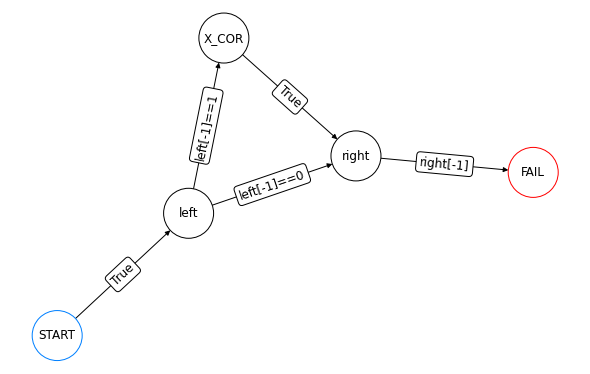

In [5]:
basic.draw(figsize=(8,5))

In [6]:
err_model = qs.noise.E1
q = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5]
err_params = {'q': q}

In [7]:
begin = time.time()
ss_sam = qs.SubsetSampler(protocol=basic, simulator=qs.StabilizerSimulator,  p_max={'q': 0.1}, err_model=err_model, err_params=err_params, L=3)
ss_sam.run(10)
end = time.time()
qsample_time = end-begin

p=('1.00e-01',):   0%|          | 0/10 [00:00<?, ?it/s]

## STIM

In [8]:
left = """DEPOLARIZE1({q}) 0\n
                    M 0\n
                    DETECTOR rec[-1]
                      """

right = """M 0\nDETECTOR rec[-1]\n"""

x_cor = """X 0\n"""

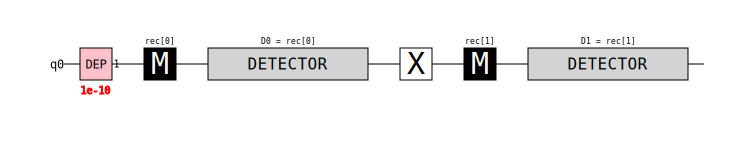

In [9]:
circuit = stim.Circuit((left+x_cor+right).format(q=1e-10))
circuit.diagram('timeline-svg')

In [10]:
B = node(right)
xB = node(x_cor+right)

A = node(left)
A.outcomes={0: B, 1: xB}

B.outcomes = {0:"OK", 1:"FAIL"}
xB.outcomes =B.outcomes

In [11]:
err_total = np.zeros(len(q))
begin = time.time()
paths, circuits = A.fail_paths()
for p in range(len(paths)):
    
    circuit = stim.Circuit(circuits[p].format(q=1e-10)) #arbitrary error rate
    dem = circuit.detector_error_model()
    
    sampler = circuit.compile_sampler()
    outcome = sampler.sample(shots=1)
    paths[p]-=outcome[0]
    errors, errloc = dem2matrices(repr(dem),len(paths[p]))
    err = len(errors)
    depth = len(paths[p])
    extracted, extracted_indices = separate_errors(errloc, depth)
    
    #n_samples = np.prod([len(i)**(2*(len(i)>1)) for i in extracted])
    #print(n_samples)
    n_samples=10
    result = sample_errors(n_samples, depth, paths[p], errloc, extracted, extracted_indices)

    for i in range(len(q)):
        circuit = stim.Circuit(circuits[p].format(q=q[i]))
        dem = circuit.detector_error_model()
        errors, errloc = dem2matrices(repr(dem),len(paths[p]))
        if len(result)>0:
            err_total[i]+= np.sum(np.prod(errors*result+(1-errors)*(1-result), axis=1))

end = time.time()
stim_time = end-begin

# Comparison

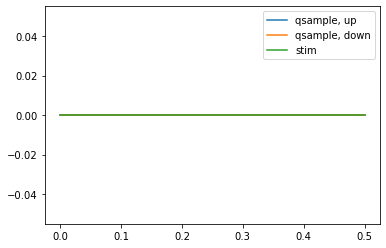

In [12]:
plt.plot(q, ss_sam.stats()[0], label = 'qsample, up')
plt.plot(q, ss_sam.stats()[2], label = 'qsample, down')
plt.plot(q, err_total, label = 'stim')
plt.legend()

In [13]:
print("QSample time: {:.3}s".format(qsample_time))
print("STIM time: {:.3}s".format(stim_time))
print(qsample_time/stim_time)

QSample time: 0.0423s
STIM time: 0.00244s
17.33391984359726
